In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [ ]:
lookupTable = {
    'None': 3,
    'Distrust in institutions': 2,
    'Political hate and polarisation': 0,
    'Distrust in democratic system': 5,
    'Geopolitics': 8,
    'Anti-Elites': 9,
    'Anti-EU': 1,
    'Gender-related': 10,
    'Ethnicity-related': 6,
    'Migration-related': 7,
    'Religion-related': 4
}

In [ ]:
people = ['gdhande', 'Munesh', 'nivedita', 'Shweta', 'Swapnanil', 'Sharath']
dfs = []

for i,person in enumerate(people):
    df = pd.read_csv(f'data/s{i+1}.csv')
    df = df.rename(columns={'tweet': 'feature', f'annotations.{person}.supernarrative_1' : 'label'})
    df['label'] = df['label'].fillna('None')
    df['label'] = df['label'].map(lookupTable)
    
    df = df[['feature', 'label']]
    dfs.append(df)

df = pd.concat(dfs,ignore_index=False)

X_train = df['feature'].tolist()
y_train = df['label']


df_test = pd.read_csv('data/test.csv',encoding='latin1')
X_test = df_test['original_tweet'].tolist()
y_test = df_test['label'].tolist()

In [23]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:

# Function to get BERT embeddings for a list of texts
def get_bert_embeddings(texts, batch_size=32):
    embeddings_list = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Ensure inputs are a list of strings
        if not isinstance(batch_texts, list):
            batch_texts = [batch_texts]

        # Print the current batch of texts to verify format
        #print("\nCurrent Batch of Texts:\n", batch_texts)

        # Tokenize the input texts directly using the tokenizer object
        encoded_inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=144,
            return_tensors='pt'
        )

        # Process the inputs with BERT to obtain outputs
        with torch.no_grad():
            outputs = bert_model(**encoded_inputs)

        # Extract the embedding of the [CLS] token for classification
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings_list.append(batch_embeddings)

    return np.concatenate(embeddings_list, axis=0)

In [25]:
# Obtain BERT embeddings for the training and testing data
X_train_embeddings = get_bert_embeddings(X_train)
X_test_embeddings = get_bert_embeddings(X_test)

In [26]:
# Standardize embeddings
scaler = StandardScaler()
X_train_embeddings = scaler.fit_transform(X_train_embeddings)
X_test_embeddings = scaler.transform(X_test_embeddings)

In [27]:
# Train a simple classifier on the BERT embeddings
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_embeddings, y_train)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [28]:
# Make predictions
y_pred = classifier.predict(X_test_embeddings)

In [31]:
y_test = y_test.tolist()

In [32]:
#export classification report as csv
report = classification_report(y_test, y_pred)


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Export the classification report to a CSV file
report_path = r'perf_reports\bert.csv'
with open(report_path, 'w') as f:
    f.write(report)

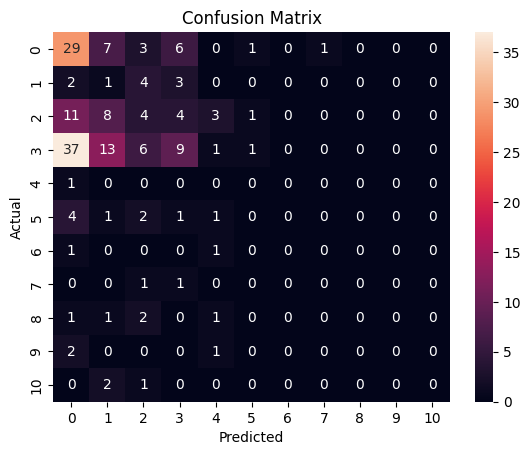

In [ ]:
# Export confusion matrix as png

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('imgs/bert_cm.png')